In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [198]:
data = pd.read_csv(r'C:\Users\dvale\TFM\Data\all_variables.csv')

In [199]:
print(data.shape)
print(data.columns)

(39852, 20)
Index(['Unnamed: 0', 'id', 'weight', 'material_deprivation', 'sex', 'age',
       'civil_status', 'familial_status', 'region', 'population_density',
       'citizenship', 'tenure_status', 'education_level', 'working_status',
       'working_status_agg', 'occupation', 'economic_sector', 'years_worked',
       'hours_week_worked', 'income'],
      dtype='object')


In [200]:
data = data.drop(['Unnamed: 0', 'id', 'weight', 'economic_sector', 'income'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39852 entries, 0 to 39851
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   material_deprivation  39852 non-null  object
 1   sex                   39852 non-null  object
 2   age                   39852 non-null  int64 
 3   civil_status          39852 non-null  object
 4   familial_status       39852 non-null  object
 5   region                39852 non-null  object
 6   population_density    39852 non-null  object
 7   citizenship           39852 non-null  object
 8   tenure_status         39852 non-null  object
 9   education_level       39852 non-null  object
 10  working_status        39852 non-null  object
 11  working_status_agg    39852 non-null  object
 12  occupation            39852 non-null  object
 13  years_worked          39852 non-null  int64 
 14  hours_week_worked     39852 non-null  int64 
dtypes: int64(3), object(12)
memory usage

In [201]:
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed',
       'Self-employed', 'Minor'], dtype=object)

In [202]:
data.working_status = np.where(data.working_status == 'Self-employed', 'Employed', data.working_status)
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed',
       'Minor'], dtype=object)

In [203]:
data = data.drop(['working_status_agg'], axis=1)

In [204]:
scaler = StandardScaler()

num_var = data[['age', 'years_worked', 'hours_week_worked']]
scaler.fit(num_var)
scaled_var = pd.DataFrame(scaler.transform(num_var), columns=num_var.columns)

data.age = scaled_var.age
data.years_worked = scaled_var.years_worked
data.years_worked = scaled_var.years_worked

data.head()

,material_deprivation,sex,age,civil_status,familial_status,region,population_density,citizenship,tenure_status,education_level,working_status,occupation,years_worked,hours_week_worked
0,No,Male,1.088573,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,Clerical Support Workers,1.831752,0
1,No,Female,1.002616,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Unpaid carer/domestic worker,Clerical Support Workers,-0.922952,0
2,No,Female,1.174531,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Lower secondary education,Unpaid carer/domestic worker,Elementary Occupations,0.178930,0
3,No,Male,0.658786,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,Services and Sales Workers,1.097164,0
4,No,Female,0.400914,Divorced,Yes,Basque Country,Thinly-populated area,Spain,Outright owner,Higher education,Disabled/unfit to work,Services and Sales Workers,0.791086,0


In [205]:
def get_dummies(df):
    new_df = pd.DataFrame()
    for c in df.columns:
        if type(df[c][0]) == type('string'):
            dummy_df = pd.get_dummies(df[c])
            for dummy_column in dummy_df.columns:
                new_df[c + '_' + dummy_column] = dummy_df[dummy_column]
        else:
            new_df[c] = df[c]
    return new_df

In [206]:
data_final = get_dummies(data[data.columns[1:]])

data_final.columns[:5]

Index(['sex_Female', 'sex_Male', 'age', 'civil_status_Divorced',
       'civil_status_Married'],
      dtype='object')

In [207]:
data_final['is_minor'] = data_final.civil_status_Minor
data_final = data_final.drop(['civil_status_Minor', 
                               'working_status_Minor', 
                               'education_level_Minor'], axis=1)

In [208]:
data_final['material_deprivation'] = data.material_deprivation.map({'Yes': 1, 'No': 0})

count_yes = len(data_final[data_final.material_deprivation == 1])
count_no = len(data_final[data_final.material_deprivation == 0])
freq_yes = (count_yes/(count_yes+count_no))*100
freq_no = (count_no/(count_yes+count_no))*100

print('''Has material deprivation: {}%
Does not have material deprivation: {}%'''.format(round(freq_yes, 2), round(freq_no, 2)))

Has material deprivation: 4.61%
Does not have material deprivation: 95.39%


In [209]:
data_final.head()

,sex_Female,sex_Male,age,civil_status_Divorced,civil_status_Married,civil_status_Married 'de facto',civil_status_Never married,civil_status_Separated,civil_status_Widowed,familial_status_No,...,occupation_Managers,occupation_Plant and Machine Operators and Assemblers,occupation_Professionals,occupation_Services and Sales Workers,"occupation_Skilled Agricultural, Forestry and Fishery Workers",occupation_Technicians and Associate Professionals,years_worked,hours_week_worked,is_minor,material_deprivation
0,0,1,1.088573,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1.831752,0,0,0
1,1,0,1.002616,0,1,0,0,0,0,1,...,0,0,0,0,0,0,-0.922952,0,0,0
2,1,0,1.174531,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0.178930,0,0,0
3,0,1,0.658786,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1.097164,0,0,0
4,1,0,0.400914,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0.791086,0,0,0


In [210]:
X = data_final.drop(['material_deprivation'], axis=1)
y = data_final.material_deprivation

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [211]:
training_data = X_train.copy()
training_data['material_deprivation'] = y_train.copy()
training_data_us = pd.concat([training_data[training_data.material_deprivation == 1], 
                              training_data[training_data.material_deprivation == 0].sample(frac=0.0461)]).sample(frac=1)

X_train_us = training_data_us.drop(['material_deprivation'], axis=1)
y_train_us = training_data_us.material_deprivation

In [212]:
logreg = LogisticRegression(max_iter=1000)

rfe = RFE(logreg)
rfe = rfe.fit(X_train_us, y_train_us)
             
selected_columns = [X_train.columns[i] for i in range(len(rfe.support_)) if rfe.support_[i] == True]
selected_columns

['civil_status_Divorced',
 'civil_status_Married',
 "civil_status_Married 'de facto'",
 'civil_status_Separated',
 'civil_status_Widowed',
 'region_Andalusia',
 'region_Aragon',
 'region_Balearic Islands',
 'region_Basque Country',
 'region_Cantabria',
 'region_Extremadura',
 'region_Galicia',
 'region_La Rioja',
 'region_Melilla',
 'region_Region of Murcia',
 'population_density_Thinly-populated area',
 'citizenship_Other (outside EU)',
 'citizenship_Spain',
 'tenure_status_Accommodation is rented at a reduced rate (lower price than the market price)',
 'tenure_status_Outright owner',
 'tenure_status_Owner paying mortgage',
 'education_level_Higher education',
 'education_level_Pre-primary education',
 'education_level_Upper secondary education',
 'working_status_Disabled/unfit to work',
 'working_status_Employed',
 'working_status_Unemployed',
 'occupation_Elementary Occupations',
 'occupation_Food Preparation Assistants',
 'occupation_Plant and Machine Operators and Assemblers',
 'o

In [213]:
X_train_us = X_train_us[selected_columns]
X_test = X_test[selected_columns]

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_us, y_train_us)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.77


In [214]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7338 2166]
 [ 100  359]]


In [215]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      9504
           1       0.14      0.78      0.24       459

    accuracy                           0.77      9963
   macro avg       0.56      0.78      0.55      9963
weighted avg       0.95      0.77      0.84      9963



In [216]:
proba_material_deprivation = [proba[1] for proba in logreg.predict_proba(X_test)]

In [217]:
testing_data = X_test.copy()
testing_data['material_deprivation'] = y_test.copy()
testing_data['proba_material_deprivation'] = proba_material_deprivation

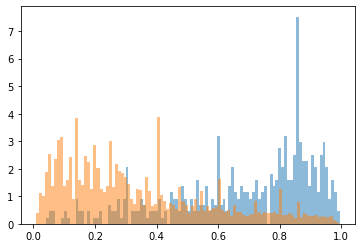

In [218]:
plt.hist(x='proba_material_deprivation', bins=100, data=testing_data[testing_data.material_deprivation == 1].reset_index(), 
         alpha=0.5, density=True)
plt.hist(x='proba_material_deprivation', bins=100, data=testing_data[testing_data.material_deprivation == 0].reset_index(), 
         alpha=0.5, density=True);